NESTML active dendrite third-factor STDP synapse
==========================================

In this tutorial, the neuron with dendritic action potentials from the [NESTML active dendrite tutorial](https://nestml.readthedocs.io/en/latest/tutorials/active_dendrite/nestml_active_dendrite_tutorial.html) is combined with a spike-timing dependent synaptic plasticity model. The dendritic action potential current acts as the "third factor" in the learning rule (in addition to pre- and postsynaptic spike timings) and is used to gate the weight update: changes in the weight can only occur during the postsynaptic neuron's dendritic action potential.

### Notes on how third-factor plasticity rules are simulated

When a continuous-time input port is defined in the synapse model which is connected to a postsynaptic neuron, a corresponding buffer is allocated in each neuron which retains the recent history of the needed state variables. Two options are available for how the buffer is implemented: a "continuous-time" based buffer, or a spike-based buffer (see the NEST code generator option ``continuous_state_buffering_method`` on https://nestml.readthedocs.io/en/latest/pynestml.codegeneration.html#pynestml.codegeneration.nest_code_generator.NESTCodeGenerator).

By default, the "continuous-time" based buffer is selected. This covers the most general case of different synaptic delay values and a discontinuous third-factor signal. The implementation corresponds to the event-based update scheme in Fig. 4b of [Stapmanns2021]_. There, the authors observe that the storage and management of such a buffer can be expensive in terms of memory and runtime. In each time step, the value of the current dendritic current (or membrane potential, or other third factor) is appended to the buffer. The maximum length of the buffer depends on the maximum inter-spike interval of any of the presynaptic neurons.

As a computationally more efficient alternative, a spike-based buffer can be selected. In this case, the third factor is not stored every timestep, but only upon the occurrence of postsynaptic (somatic) spikes. Because of the existence of a nonzero dendritic delay, the time at which the somatic spike is observed at the soma is delayed, and the time at which the third factor is sampled should match the time of the spike at the synapse, rather than the soma. When the spike-based buffering method is used, the dendritic delay is therefore ignored, because the third factor is sampled instead at the time of the somatic spike.

In this tutorial, we will first use the default (continuous-time) buffer, and then switch to the spike-based buffer and observe the differences.

In [1]:
%matplotlib inline

from typing import List, Optional

import matplotlib as mpl

mpl.rcParams['axes.formatter.useoffset'] = False
mpl.rcParams['axes.grid'] = True
mpl.rcParams['grid.color'] = 'k'
mpl.rcParams['grid.linestyle'] = ':'
mpl.rcParams['grid.linewidth'] = 0.5
mpl.rcParams['figure.dpi'] = 120
mpl.rcParams['figure.figsize'] = [8., 3.]

import matplotlib.pyplot as plt
import nest
import numpy as np
import os
import random
import re

from pynestml.codegeneration.nest_code_generator_utils import NESTCodeGeneratorUtils
from pynestml.codegeneration.nest_tools import NESTTools


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.7.0-post0.dev0
 Built: Jun 20 2024 10:38:05

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



## Reference model

First we define some helper functions that we can use to simulate the desired behaviour of the learning rule. We can then test that the NESTML model behaves in exactly the same way to validate the method.

In [2]:
def get_trace_at(t, t_spikes, tau, initial=0., increment=1., before_increment=True, extra_debug=False):
    if extra_debug:
        print("\t-- obtaining trace at t = " + str(t))
    if len(t_spikes) == 0:
        return initial
    tr = initial
    t_sp_prev = 0.
    for t_sp in t_spikes:
        if t_sp > t:
            break
        if extra_debug:
            _tr_prev = tr
        tr *= np.exp(-(t_sp - t_sp_prev) / tau)
        if t_sp == t:  # exact floating point match!
            if before_increment:
                if extra_debug:
                    print("\t   [%] exact (before_increment = T), prev trace = " + str(_tr_prev) + " at t = " + str(t_sp_prev)
                          + ", decayed by dt = " + str(t - t_sp_prev) + ", tau = " + str(tau) + " to t = " + str(t) + ": returning trace: " + str(tr))
                return tr
            else:
                if extra_debug:
                    print("\t   [%] exact (before_increment = F), prev trace = " + str(_tr_prev) + " at t = " + str(t_sp_prev) + ", decayed by dt = " + str(
                        t - t_sp_prev) + ", tau = " + str(tau) + " to t = " + str(t) + ": returning trace: " + str(tr + increment))
                return tr + increment
        tr += increment
        t_sp_prev = t_sp
    if extra_debug:
        _tr_prev = tr
    tr *= np.exp(-(t - t_sp_prev) / tau)
    if extra_debug:
        print("\t   [&] prev trace = " + str(_tr_prev) + " at t = " + str(t_sp_prev) + ", decayed by dt = "
              + str(t - t_sp_prev) + ", tau = " + str(tau) + " to t = " + str(t) + ": returning trace: " + str(tr))
    return tr

In [3]:
def run_reference_simulation(pre_spike_times,
                             post_spike_times,
                             stepwise_times,
                             stepwise_values,
                             delay,
                             verbose=True):
    lmbda = 1E-6
    tau_tr_pre = 10.
    tau_tr_post = 10.
    alpha = 1.
    mu_plus = 0.
    mu_minus = 0.
    Wmax = 100.
    Wmin = 0.
    third_factor_max = 100.

    post_spike_times = list(np.array(post_spike_times) + delay)  # + delay to make the post spike times
                                                                 # from the synapse perspective
    
    stepwise_state = 0
    third_factor = stepwise_values[0] / third_factor_max
    w = 1.
    t_log = [0.]
    w_log = [w]
    third_factor_log = [third_factor]

    for t in np.unique(sorted(pre_spike_times + post_spike_times)):
        pre_trace = get_trace_at(t, pre_spike_times, tau_tr_pre, extra_debug=False)
        post_trace = get_trace_at(t, post_spike_times, tau_tr_post, extra_debug=False)

        while stepwise_state < len(stepwise_times) - 1 and t >= stepwise_times[stepwise_state + 1]:
            stepwise_state += 1

        if stepwise_values[stepwise_state] is not None:
            third_factor = stepwise_values[stepwise_state] / third_factor_max

        if verbose:
            print("[t = " + str(t) + "] 3rd factor = " + str(third_factor))
        
        if t in post_spike_times:
            # potentiate synapse
            w_ = Wmax * ( w / Wmax  + (lmbda * ( 1. - ( w / Wmax ) )**mu_plus * pre_trace ))
            w_ = third_factor * w_ + (1 - third_factor) * w   # "gating" of the weight update
            w = min(Wmax, w_)
            if verbose:
                print("\tAt t = " + str(t) + ", post spike")
                print("\t---> pre_tr = " + str(pre_trace) + ", new weight = " + str(w))

        if t in pre_spike_times:
            # depress synapse
            w_ = Wmax * ( w / Wmax  - ( alpha * lmbda * ( w / Wmax )**mu_minus * post_trace ))
            w_ = third_factor * w_ + (1 - third_factor) * w   # "gating" of the weight update
            w = max(Wmin, w_)
            if verbose:
                print("\tAt t = " + str(t) + ", pre spike")
                print("\t---> post_tr = " + str(post_trace) + ", new weight = " + str(w))

        t_log.append(t)
        w_log.append(w)
        third_factor_log.append(third_factor)
        
    return t_log, w_log, third_factor_log

In [4]:
def plot_reference_simulation(t_log, w_log, third_factor_log, delay, pre_spike_times, post_spike_times):
    
    sim_time = np.amax(t_log)
    
    fig, ax = plt.subplots(nrows=5, figsize=(8, 7))

    n_spikes = len(pre_spike_times)
    for i in range(n_spikes):
        ax[0].plot(2 * [pre_spike_times[i]], [0, 1], linewidth=2, color="blue", alpha=.4)

    ax[0].set_ylabel("Pre spikes")

    n_spikes = len(post_spike_times)
    for i in range(n_spikes):
        ax[-4].plot(2 * [post_spike_times[i] + delay], [0, 1], linewidth=2, color="black", alpha=.4)
    ax[-4].set_ylabel("Post spikes")

    ax[-3].plot(t_log, third_factor_log)
    ax[-3].set_ylim(0, 1.1 * np.amax(third_factor_log))
    ax[-3].set_ylabel("3rd factor")

    ax[-2].semilogy(t_log[:-1], np.abs(np.diff(w_log)), marker="o", label=u"Δw")
    ax[-2].set_ylabel(u"|Δw|")

    ax[-1].plot(t_log, w_log, marker="o")
    ax[-1].set_ylabel("w")
    ax[-1].set_xlabel("Time [ms]")
    for _ax in ax:
        if not _ax == ax[-1]:
            _ax.set_xticklabels([])
        _ax.grid(True)
        _ax.set_xlim(0., sim_time)

    fig.savefig("/tmp/stdp_third_factor_synapse_test_ref.png", dpi=300)

A simple example:

[t = 15.0] 3rd factor = 1.0
	At t = 15.0, pre spike
	---> post_tr = 0.0, new weight = 1.0
[t = 20.0] 3rd factor = 1.0
	At t = 20.0, post spike
	---> pre_tr = 0.6065306597126334, new weight = 1.0000606530659713
[t = 55.0] 3rd factor = 1.0
	At t = 55.0, pre spike
	---> post_tr = 0.0301973834223185, new weight = 1.000057633327629
[t = 60.0] 3rd factor = 1.0
	At t = 60.0, post spike
	---> pre_tr = 0.6176396562508758, new weight = 1.000119397293254
[t = 90.0] 3rd factor = 1.0
	At t = 90.0, pre spike
	---> post_tr = 0.050698950333418466, new weight = 1.0001143273982207
[t = 105.0] 3rd factor = 1.0
	At t = 105.0, post spike
	---> pre_tr = 0.22999151695160197, new weight = 1.0001373265499158
[t = 130.0] 3rd factor = 1.0
	At t = 130.0, pre spike
	---> post_tr = 0.08301358229024355, new weight = 1.0001290251916868
[t = 145.0] 3rd factor = 1.0
	At t = 145.0, post spike
	---> pre_tr = 0.22734260172038753, new weight = 1.0001517594518587
[t = 150.0] 3rd factor = 1.0
	At t = 150.0, pre spike
	---> p

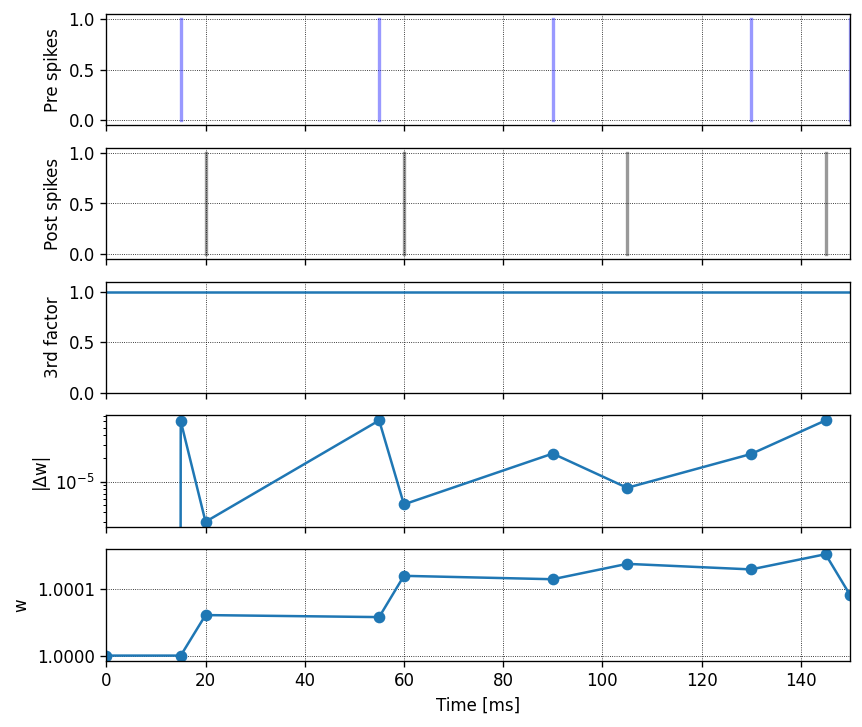

In [5]:
pre_spike_times = [15., 55., 90., 130., 150.]      # [ms]
post_spike_times = [10., 50., 95., 135.]      # [ms]

delay = 10.    # [ms]

t_log, w_log, third_factor_log = run_reference_simulation(pre_spike_times=pre_spike_times,
                                                          post_spike_times=post_spike_times,
                                                          stepwise_times=[0.],
                                                          stepwise_values=[100.],
                                                          delay=delay)

plot_reference_simulation(t_log, w_log, third_factor_log, delay, pre_spike_times, post_spike_times)

## Generating code with NESTML

We use the same neuron model as in the tutorial, except for adding the ``reset_I_dAP_after_AP`` flag that makes a reset to zero of the dAP current optional.

In [6]:
nestml_neuron_model = '''
model iaf_psc_exp_active_dendrite_neuron:
    state:
        V_m mV = 0 mV     # membrane potential
        t_dAP ms = 0 ms   # dendritic action potential timer
        I_dAP pA = 0 pA   # dendritic action potential current magnitude

    equations:
        # alpha shaped postsynaptic current kernel
        kernel syn_kernel = (e / tau_syn) * t * exp(-t / tau_syn)
        kernel sg_kernel = delta(t)
        recordable inline I_syn pA = convolve(syn_kernel, synaptic_spikes) * pA
        V_m' = -(V_m - E_L) / tau_m + (I_syn + I_dAP + I_e) / C_m + convolve(sg_kernel, spike_generator_spikes) * mV / s
        I_dAP' = -I_dAP / tau_dAP

    parameters:
        C_m pF = 250 pF          # capacity of the membrane
        tau_m ms = 20 ms         # membrane time constant
        tau_syn ms = 10 ms       # time constant of synaptic current
        V_th mV = 25 mV          # action potential threshold
        V_reset mV = 0 mV        # reset voltage
        I_e    pA = 0 pA         # external current
        E_L    mV = 0 mV         # resting potential

        # dendritic action potential
        I_th pA = 100 pA         # current threshold for a dendritic action potential
        I_dAP_peak pA = 100 pA   # current clamp value for I_dAP during a dendritic action potential
        T_dAP ms = 10 ms         # time window over which the dendritic current clamp is active
        tau_dAP ms = 100 ms         # if ``reset_I_dAP_after_AP`` is false, I_dAP decays back to zero with this time constant
        reset_I_dAP_after_AP boolean = true

    input:
        synaptic_spikes <- spike
        spike_generator_spikes <- spike

    output: 
        spike

    update:
        # solve ODEs
        if reset_I_dAP_after_AP:
            integrate_odes(V_m)
        else:
            integrate_odes(V_m, I_dAP)

        if t_dAP > 0 ms:
            t_dAP -= resolution()
            if t_dAP <= 0 ms:
                # end of dendritic action potential
                t_dAP = 0 ms
                if reset_I_dAP_after_AP:
                    I_dAP = 0 pA

    onCondition(I_syn > I_th):
        # current-threshold, emit a dendritic action potential
        t_dAP = T_dAP
        I_dAP = I_dAP_peak

    onCondition(V_m > V_th):
        # emit somatic action potential
        emit_spike()
        V_m = V_reset
        I_syn = 0 pA
'''

For the synapse model, we begin with the normal STDP model, but add the ``I_post_dend`` continuous input port, and use its value to gate the weight updates in the ``onReceive`` blocks.

In [7]:
nestml_synapse_model = '''
"""
third_factor_stdp_synapse - Synapse model for spike-timing dependent plasticity with postsynaptic third-factor modulation
#########################################################################################################################

Description
+++++++++++

third_factor_stdp_synapse is a synapse with spike time dependent plasticity (as defined in [1]). Here the weight dependence exponent can be set separately for potentiation and depression. Examples::

For references and more details, please see the original stdp_synapse model.
"""
model third_factor_stdp_synapse:
    state:
        w real = 1.    # Synaptic weight

    parameters:
        d ms = 1 ms    # Postsynaptic dendritic delay
        lambda real = .01
        tau_tr_pre ms = 10 ms
        tau_tr_post ms = 10 ms
        alpha real = 1.
        mu_plus real = 1.
        mu_minus real = 1.
        Wmax real = 100.
        Wmin real = 0.
        I_post_dend_peak pA = 100 pA   # current clamp value for I_dAP during a dendritic action potential

    equations:
        kernel pre_trace_kernel = exp(-t / tau_tr_pre)
        inline pre_trace real = convolve(pre_trace_kernel, pre_spikes)

        # all-to-all trace of postsynaptic neuron
        kernel post_trace_kernel = exp(-t / tau_tr_post)
        inline post_trace real = convolve(post_trace_kernel, post_spikes)

    input:
        pre_spikes <- spike
        post_spikes <- spike
        I_post_dend pA <- continuous

    output:
        spike

    onReceive(post_spikes):
        # potentiate synapse
        w_ real = Wmax * ( w / Wmax  + (lambda * ( 1. - ( w / Wmax ) )**mu_plus * pre_trace ))
        if I_post_dend <= I_post_dend_peak:
            w_ = (I_post_dend / I_post_dend_peak) * w_ + (1 - I_post_dend / I_post_dend_peak) * w   # "gating" of the weight update
        w = min(Wmax, w_)

    onReceive(pre_spikes):
        # depress synapse
        w_ real = Wmax * ( w / Wmax  - ( alpha * lambda * ( w / Wmax )**mu_minus * post_trace ))
        if I_post_dend <= I_post_dend_peak:
            w_ = (I_post_dend / I_post_dend_peak) * w_ + (1 - I_post_dend / I_post_dend_peak) * w   # "gating" of the weight update
        w = max(Wmin, w_)

        # deliver spike to postsynaptic partner
        emit_spike(w, d)

    update:
        integrate_odes()

'''

We will use a helper function, ``generate_code_for()``, to generate the C++ code for the models and build it as a NEST extension module. Afterwards we will be able to dynamically load the module into the kernel using ``nest.Install()``.

In [8]:
from pynestml.codegeneration.nest_code_generator_utils import NESTCodeGeneratorUtils

codegen_opts = {"neuron_synapse_pairs": [{"neuron": "iaf_psc_exp_active_dendrite_neuron",
                                          "synapse": "third_factor_stdp_synapse",
                                          "post_ports": ["post_spikes",
                                                         ["I_post_dend", "I_dAP"]]}],
                "delay_variable": {"third_factor_stdp_synapse": "d"},
                "weight_variable": {"third_factor_stdp_synapse": "w"},
                "continuous_state_buffering_method": "continuous_time_buffer"} # the default option!

module_name, neuron_model_name, synapse_model_name = \
    NESTCodeGeneratorUtils.generate_code_for(nestml_neuron_model,
                                             nestml_synapse_model,
                                             codegen_opts=codegen_opts,
                                             logging_level="ERROR")  # try "DEBUG" for more debug information


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.7.0-post0.dev0
 Built: Jun 20 2024 10:38:05

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.

CMake Warning (dev) at CMakeLists.txt:95 (project):
  cmake_minimum_required() should be called prior to this top-level project()
  call.  Please see the cmake-commands(7) manual for usage documentation of
  both commands.
This warning is for project developers.  Use -Wno-dev to suppress it.

-- The CXX compiler identification is GNU 12.3.0
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done

-------------------------------------------------------
nestml_4495c16351934d1ba69770d8884896cb_module Co

GeneratedCodeBuildException: Error occurred during 'make all'! More detailed error messages can be found in stderr.

Now, the NESTML model is ready to be used in a simulation by calling ``nest.Install("nestmlmodule")``.

Numerical validation
--------------------

We will run some validation experiments for a small, predefined set of pre- and postsynaptic spike times.

Note that in NEST, the weight update is only computed upon presynaptic spikes. Postsynaptic spikes are buffered and only processed when the next presynaptic spike arrives. This means that the weight values are only expected to match between NEST and the reference simulation at presynaptic spike times. We also make sure to have a presynaptic spike at the very end of the simulation, such that the weight value is updated yielding the final value of the weight.

In [ ]:
def run_synapse_test(module_name,
                     neuron_model_name,
                     synapse_model_name,
                     resolution=1.,    # [ms]
                     delay=1.,    # [ms]
                     sim_time=None,    # if None, computed from pre and post spike times
                     pre_spike_times=None,    # list of pre spike times (note delay between spike generator and neuron!)
                     post_spike_times=None,    # list of post spike times (note delay between spike generator and neuron!)
                     fname_snip="",
                     stepwise_times=None,
                     stepwise_values=None,
                     reset_I_dAP_after_AP=True,
                     validate=True):  # perform validation of NESTML sim using run_reference_simulation()
    r"""
    Run a simulation for two neurons (of type ``neuron_model_name``) connected by a synapse 
    (of type ``synapse_model_name``). The pre- and postsynaptic neuron are made to fire by
    connected spike generators with times given by ``pre_spike_times`` and ``post_spike_times``.
    
    A stepwise-linear third factor can be supplied via the arrays ``stepwise_times`` and
    ``stepwise_values`` such that at each time :math:`t_i` in ``stepwise_times``, the value
    of the third factor is ``stepwise_values[i]`` for :math:`t_i <= t < t_{i+1}`.
    
    Plot the results.
    
    If ``validate`` is True, run the reference simulation to validate that the results from the
    simulation are numerically correct.
    """
    
    
    if pre_spike_times is None:
        pre_spike_times = []

    if post_spike_times is None:
        post_spike_times = []

    pre_spike_times = np.array(pre_spike_times)
    post_spike_times = np.array(post_spike_times)
        
    if sim_time is None:
        sim_time = max(np.amax(pre_spike_times), np.amax(post_spike_times)) + 1.1 * delay

    nest.ResetKernel()
    nest.set_verbosity("M_ALL")
    nest.Install(module_name)

    nest.SetKernelStatus({"resolution": resolution})

    wr = nest.Create("weight_recorder")
    nest.CopyModel(synapse_model_name, "stdp_nestml_rec",
                    {"weight_recorder": wr[0], "w": 1., "d": delay, "receptor_type": 0, "lambda": 1E-6,
                    "mu_plus": 0.,   # for additive STDP
                    "mu_minus": 0.})   # for additive STDP

    # create spike_generators with these times
    pre_sg = nest.Create("spike_generator",
                         params={"spike_times": pre_spike_times})
    post_sg = nest.Create("spike_generator",
                            params={"spike_times": post_spike_times,
                                    "allow_offgrid_times": True})

    # create parrot neurons and connect spike_generators
    pre_neuron = nest.Create("parrot_neuron")
    post_neuron = nest.Create(neuron_model_name)
    post_neuron.I_th = 1500.
    post_neuron.I_dAP_peak = 10.
    post_neuron.reset_I_dAP_after_AP = reset_I_dAP_after_AP
    receptor_types = nest.GetStatus(post_neuron, "receptor_types")[0]

    spikedet_pre = nest.Create("spike_recorder")
    spikedet_post = nest.Create("spike_recorder")
    mm = nest.Create("multimeter", params={"record_from": ["V_m", "I_dAP"]})

    nest.Connect(pre_sg, pre_neuron, "one_to_one", syn_spec={"delay": 1.})
    nest.Connect(post_sg, post_neuron, "one_to_one", syn_spec={"delay": 1.,
                                                               "weight": 100000.,
                                                               "receptor_type" : receptor_types["SPIKE_GENERATOR_SPIKES"]})
    nest.Connect(pre_neuron, post_neuron, "all_to_all", syn_spec={"synapse_model": "stdp_nestml_rec",
                                                                  "receptor_type" : receptor_types["SYNAPTIC_SPIKES"]})
    nest.Connect(mm, post_neuron)
    nest.Connect(pre_neuron, spikedet_pre)
    nest.Connect(post_neuron, spikedet_post)

    # get STDP synapse and weight before protocol
    syn = nest.GetConnections(source=pre_neuron, synapse_model="stdp_nestml_rec")

    t = 0.
    t_hist = []
    w_hist = []
    state = 0
    while t <= sim_time:
        if stepwise_times is not None and stepwise_values is not None:
            assert len(stepwise_times) == len(stepwise_values)
            
            if state < len(stepwise_times) - 1 and t >= stepwise_times[state + 1]:
                state += 1

            if stepwise_values[state] is not None:
                nest.SetStatus(post_neuron, {"I_dAP": stepwise_values[state]})
                nest.SetStatus(post_neuron, {"t_dAP": 1.})

        nest.Simulate(resolution)
        t += resolution
        t_hist.append(t)
        w_hist.append(nest.GetStatus(syn)[0]["w"])

    third_factor_trace = nest.GetStatus(mm, "events")[0]["I_dAP"] / syn[0].I_post_dend_peak
    timevec = nest.GetStatus(mm, "events")[0]["times"]

    if validate:
        t_log_ref, w_log_ref, third_factor_log_ref = run_reference_simulation(
                            pre_spike_times=list(np.array(pre_spike_times) + 1.),  # + 1 because of delay from spike gen to neuron
                            post_spike_times=list(np.array(post_spike_times) + 1.),  # + 1 because of delay from spike gen to neuron
                            stepwise_times=stepwise_times,
                            stepwise_values=stepwise_values,
                            delay=delay)

    fig, ax = plt.subplots(nrows=6, figsize=(8, 8))

    pre_spike_times_ = nest.GetStatus(spikedet_pre, "events")[0]["times"]
    np.testing.assert_allclose(pre_spike_times_, pre_spike_times + 1.)  # + 1 because of delay from spike gen to neuron

    n_spikes = len(pre_spike_times_)
    for i in range(n_spikes):
        ax[0].plot(2 * [pre_spike_times_[i]], [0, 1], linewidth=2, color="blue", alpha=.4)

    post_spike_times_ = nest.GetStatus(spikedet_post, "events")[0]["times"]
    np.testing.assert_allclose(post_spike_times_, post_spike_times + 1.)  # + 1 because of delay from spike gen to neuron
    ax[0].set_ylabel("Pre spikes")

    V_m = nest.GetStatus(mm, "events")[0]["V_m"]
    ax[1].plot(timevec, V_m)
    ax[1].plot([0, timevec[-1]], [post_neuron.V_th, post_neuron.V_th], c="grey", alpha=.7, linestyle="--")
    ax[1].set_ylabel("post V_m")
    
    n_spikes = len(post_spike_times_)
    for i in range(n_spikes):
        if i == 0:
            _lbl = "nestml"
        else:
            _lbl = None
        ax[-4].plot(2 * [post_spike_times_[i] + delay], [0, 1], linewidth=2, color="black", alpha=.4, label=_lbl)
    ax[-4].set_ylabel("Post spikes")

    ax[-3].plot(timevec, third_factor_trace, alpha=.8, label="NESTML")
    if validate:
        ax[-3].plot(t_log_ref, third_factor_log_ref, alpha=.8, marker="o", label="ref")
    ax[-3].legend(loc='center right')
    ax[-3].set_ylim(0, 1.1 * np.amax(third_factor_trace))
    ax[-3].set_ylabel("3rd factor")

    ax[-2].semilogy(t_hist[:-1], np.abs(np.diff(w_hist)), marker="o", label=u"Δw")
    #ax[-2].set_yscale('symlog')
    ax[-2].set_ylabel(u"|Δw|")

    ax[-1].plot(t_hist, w_hist, alpha=.8, label="nestml")
    if validate:
        ax[-1].plot(t_log_ref, w_log_ref, marker="o", alpha=.8, label="ref")
    
    ax[-1].set_ylabel("w")
    ax[-1].set_xlabel("Time [ms]")
    
    for _ax in ax:
        if not _ax == ax[-1]:
            _ax.set_xticklabels([])
        _ax.grid(True)
        _ax.set_xlim(0., sim_time)

    fig.savefig("/tmp/stdp_third_factor_synapse_test_ref_" + fname_snip + ".png", dpi=300)

    if validate:
        # check that, at the time of each pre spike (because that's when NEST synapse update their state):
        # weight computed with the reference code matches that of the NESTML generated code

        for i, t_pre in enumerate(list(np.array(pre_spike_times) + 1.)):  # + 1 because of delay from spike gen to neuron
            ref_idx = np.argmin((t_log_ref - t_pre)**2)
            numeric_result_idx = np.argmin((t_hist - t_pre)**2)
            np.testing.assert_allclose(t_log_ref[ref_idx], t_pre)
            np.testing.assert_allclose(t_hist[numeric_result_idx], t_pre)
            np.testing.assert_allclose(w_log_ref[ref_idx], w_hist[numeric_result_idx + 1])

    return timevec, t_hist, third_factor_trace, w_hist


### Case 1: Third factor is zero

This should result in no weight changes whatsoever.

In [ ]:
pre_spike_times = np.array([15., 65., 115., 165.])      # [ms]
post_spike_times = np.array([10., 60., 110.])    # [ms]

In [ ]:
timevec, t_hist, third_factor_trace, w_hist = run_synapse_test(
    module_name=module_name,
    neuron_model_name=neuron_model_name,
    synapse_model_name=synapse_model_name,
    resolution=.1,  # [ms]
    delay=2.,  # [ms]
    pre_spike_times=pre_spike_times,
    post_spike_times=post_spike_times,
    stepwise_times=[0.],
    stepwise_values=[0.])

### Case 2: Third factor is always enabled

This should result in a conventional STDP weight update.

In [ ]:
# run the simulation
timevec, t_hist, third_factor_trace, w_hist = run_synapse_test(
    module_name=module_name,
    neuron_model_name=neuron_model_name,
    synapse_model_name=synapse_model_name,
    resolution=.1,  # [ms]
    delay=1.,  # [ms]
    pre_spike_times=pre_spike_times,
    post_spike_times=post_spike_times,
    stepwise_times=[0.],
    stepwise_values=[100.])

In [ ]:
# run the simulation
timevec, t_hist, third_factor_trace, w_hist = run_synapse_test(
    module_name=module_name,
    neuron_model_name=neuron_model_name,
    synapse_model_name=synapse_model_name,
    resolution=.1,  # [ms]
    delay=1.,  # [ms]
    pre_spike_times=pre_spike_times - 5.,
    post_spike_times=post_spike_times + 5,
    stepwise_times=[0.],
    stepwise_values=[100.])

### Case 3: Third factor active during pre but not post spike

This should result in a strong depression due to the pre spike just after the post spike.

In [ ]:
pre_spike_times = np.array([15., 65., 165.])    # [ms]
post_spike_times = np.array([60.])     # [ms]

stepwise_times = [0., 64., 68.]
stepwise_values = [0., 100., 0.]

# run the simulation
timevec, t_hist, third_factor_trace, w_hist = run_synapse_test(
    module_name=module_name,
    neuron_model_name=neuron_model_name,
    synapse_model_name=synapse_model_name,
    resolution=.1,  # [ms]
    delay=1.,  # [ms]
    pre_spike_times=pre_spike_times,
    post_spike_times=post_spike_times,
    stepwise_times=stepwise_times, stepwise_values=stepwise_values)

### Case 4: Third factor active during post but not pre spike

This should result in a small potentiation, due to the pairing with the first pre spike at t = 16 ms.

In [ ]:
sim_time = 101.

stepwise_times = [0., 59., 63.]
stepwise_values = [0., 100., 0.]

# run the simulation
timevec, t_hist, third_factor_trace, w_hist = run_synapse_test(
    module_name=module_name,
    neuron_model_name=neuron_model_name,
    synapse_model_name=synapse_model_name,
    resolution=.1,  # [ms]
    delay=1.,  # [ms]
    pre_spike_times=pre_spike_times,
    post_spike_times=post_spike_times,
    stepwise_times=stepwise_times,
    stepwise_values=stepwise_values)

### Case 5: Third factor active during post but not pre spike (long delays)

The dendritic action potential current is "gating" the STDP weight updates. The value of the dendritic current is taken at the time when the postsynaptic spike arrives at the synapse, taking dendritic delays into account.

Dendritic delay is now set to 10 ms, making the effect more apparent. With the same third-factor timing as in case 4, the gating is enabled during the somatic post spike, but not the post spike from the perspective of the synapse, due to the dendritic delay. Because the gate is closed at the time of arrival of the post spike, no change in the weight occurs. 

In [ ]:
# run the simulation
timevec, t_hist, third_factor_trace, w_hist = run_synapse_test(
    module_name=module_name,
    neuron_model_name=neuron_model_name,
    synapse_model_name=synapse_model_name,
    resolution=.1,  # [ms]
    delay=10.,  # [ms]
    pre_spike_times=pre_spike_times,
    post_spike_times=post_spike_times,
    stepwise_times=stepwise_times,
    stepwise_values=stepwise_values)

### Case 6: Third factor active during post but not pre spike (long delays)

We move the timing of the third factor to coincide with the (delayed) post spike, which results in a strong potentiation due to the pairing with the presynaptic spike at t = 72 ms.

In [ ]:
stepwise_times = [0., 72., 80.]
stepwise_values = [0., 100., 0.]

# run the simulation
timevec, t_hist, third_factor_trace, w_hist = run_synapse_test(
    module_name=module_name,
    neuron_model_name=neuron_model_name,
    synapse_model_name=synapse_model_name,
    resolution=.1,  # [ms]
    delay=15.,  # [ms]
    pre_spike_times=pre_spike_times,
    post_spike_times=post_spike_times,
    stepwise_times=stepwise_times,
    stepwise_values=stepwise_values)

When the third factor timing is shifted to the time of the post spike, the gate is enabled at the time of the postsynaptic spike (from the timing perspective of the synapse, that is, at the time of the postsynaptic spike plus the dendritic propagation delay).

### Case 7: pre and post spike at the same time

When a pre- and postsynaptic spike arrive at the synapse at the exact same time, the order in which these events are processed is important. Note that in the reference simulation, post spikes get processed before pre spikes; this is the same as in the default generated NESTML code. 

In [ ]:
stepwise_times = [0., 46., 55.]
stepwise_values = [0., 100., 0.]

pre_spike_times = [10., 50., 100.]
post_spike_times = [11., 49.]

# run the simulation
timevec, t_hist, third_factor_trace, w_hist = run_synapse_test(
    module_name=module_name,
    neuron_model_name=neuron_model_name,
    synapse_model_name=synapse_model_name,
    resolution=.1,  # [ms]
    delay=1.,  # [ms]
    pre_spike_times=pre_spike_times,
    post_spike_times=post_spike_times,
    stepwise_times=stepwise_times,
    stepwise_values=stepwise_values)

## Use example: Non-forced dynamics

Rather than forcing the value of I_dAP, we can also allow it to following the (ODE) dynamics defined in the model (by setting ``reset_I_dAP_after_AP`` to false), showing the gating for values between zero and the maximum value.

In [ ]:
post_spike_times = np.concatenate(([10., 50.], 60. + np.sort(np.unique(1 + np.round(2000 * np.sort(np.abs(np.random.rand(1000))))))))      # [ms]
pre_spike_times = np.sort(np.unique(1 + np.round(2000 * np.sort(np.abs(np.random.rand(1000))))))      # [ms]

stepwise_times = [0., 100., 120.]
stepwise_values = [0., 1., None]

# run the simulation
timevec, t_hist, third_factor_trace, w_hist = run_synapse_test(
    module_name=module_name,
    neuron_model_name=neuron_model_name,
    synapse_model_name=synapse_model_name,
    resolution=.5,  # [ms]
    delay=1.5,  # [ms]
    pre_spike_times=pre_spike_times,
    post_spike_times=post_spike_times,
    stepwise_times=stepwise_times,
    stepwise_values=stepwise_values,
    reset_I_dAP_after_AP=False,
    validate=False)

# Spike-based buffer

We will now generate code for the spike buffer-based method by setting the appropriate flag in the NEST code generator options. As discussed in the introduction section, the effect is that dendritic delays will be ignored.

In [ ]:
from pynestml.codegeneration.nest_code_generator_utils import NESTCodeGeneratorUtils

from pynestml.codegeneration.nest_code_generator_utils import NESTCodeGeneratorUtils

codegen_opts = {"neuron_synapse_pairs": [{"neuron": "iaf_psc_exp_active_dendrite_neuron",
                                          "synapse": "third_factor_stdp_synapse",
                                          "post_ports": ["post_spikes",
                                                         ["I_post_dend", "I_dAP"]]}],
                "delay_variable": {"third_factor_stdp_synapse": "d"},
                "weight_variable": {"third_factor_stdp_synapse": "w"},
                "continuous_state_buffering_method": "post_spike_based"} # alternative buffering method!

module_name, neuron_model_name, synapse_model_name = \
    NESTCodeGeneratorUtils.generate_code_for(nestml_neuron_model,
                                             nestml_synapse_model,
                                             codegen_opts=codegen_opts,
                                             logging_level="ERROR")  # try "DEBUG" for more debug information

Cases 5 and 6 from above should now fail, because of the large dendritic delays involved.

In [ ]:
sim_time = 101.

stepwise_times = [0., 59., 63.]
stepwise_values = [0., 100., 0.]

with pytest.raises(AssertionError, strict=True):
    timevec, t_hist, third_factor_trace, w_hist = run_synapse_test(
        module_name=module_name,
        neuron_model_name=neuron_model_name,
        synapse_model_name=synapse_model_name,
        resolution=.1,  # [ms]
        delay=10.,  # [ms]
        pre_spike_times=pre_spike_times,
        post_spike_times=post_spike_times,
        stepwise_times=stepwise_times,
        stepwise_values=stepwise_values)

In [ ]:
stepwise_times = [0., 72., 80.]
stepwise_values = [0., 100., 0.]

with pytest.raises(AssertionError, strict=True):
    timevec, t_hist, third_factor_trace, w_hist = run_synapse_test(
        module_name=module_name,
        neuron_model_name=neuron_model_name,
        synapse_model_name=synapse_model_name,
        resolution=.1,  # [ms]
        delay=15.,  # [ms]
        pre_spike_times=pre_spike_times,
        post_spike_times=post_spike_times,
        stepwise_times=stepwise_times,
        stepwise_values=stepwise_values)

However, the case where the dendritic delay is small enough so that the stepwise-changing third factor is sampled close enough to the intended timepoint, should succeed as before:

In [ ]:
pre_spike_times = np.array([15., 65., 165.])    # [ms]
post_spike_times = np.array([60.])     # [ms]

stepwise_times = [0., 64., 68.]
stepwise_values = [0., 100., 0.]

# run the simulation
timevec, t_hist, third_factor_trace, w_hist = run_synapse_test(
    module_name=module_name,
    neuron_model_name=neuron_model_name,
    synapse_model_name=synapse_model_name,
    resolution=.1,  # [ms]
    delay=1.,  # [ms]
    pre_spike_times=pre_spike_times,
    post_spike_times=post_spike_times,
    stepwise_times=stepwise_times, stepwise_values=stepwise_values)

References
----------

[1] Stapmanns, J., Hahne, J., Helias, M., Bolten, M., Diesmann, M., & Dahmen, D. (2021). Event-Based Update of Synapses in Voltage-Based Learning Rules. Frontiers in Neuroinformatics, 15, 609147. [doi:10.3389/fninf.2021.609147](https://doi.org/10.3389/fninf.2021.609147)

Acknowledgements
----------------

This software was developed in part or in whole in the Human Brain Project, funded from the European Union’s Horizon 2020 Framework Programme for Research and Innovation under Specific Grant Agreements No. 720270, No. 785907 and No. 945539 (Human Brain Project SGA1, SGA2 and SGA3).

License
-------

This notebook (and associated files) is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 2 of the License, or (at your option) any later version.

This notebook (and associated files) is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details.